<a href="https://colab.research.google.com/github/nephelim74/PythonDS/blob/main/DZ9.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 2.8 MB/s eta 0:00:00


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_20newsgroups
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score


## Загрузка данных

In [3]:
newsgroups_data = fetch_20newsgroups(subset='all')
data = {
    'text': newsgroups_data.data,
    'target': newsgroups_data.target}
df = pd.DataFrame(data)
df['category'] = df['target'].apply(lambda x: newsgroups_data.target_names[x])
df


,text,target,category
0,From: Mamatha Devineni Ratnam <mr47+@andrew.cm...,10,rec.sport.hockey
1,From: mblawson@midway.ecn.uoknor.edu (Matthew ...,3,comp.sys.ibm.pc.hardware
2,From: hilmi-er@dsv.su.se (Hilmi Eren)\nSubject...,17,talk.politics.mideast
3,From: guyd@austin.ibm.com (Guy Dawson)\nSubjec...,3,comp.sys.ibm.pc.hardware
4,From: Alexander Samuel McDiarmid <am2o+@andrew...,4,comp.sys.mac.hardware
...,...,...,...
18841,From: jim.zisfein@factory.com (Jim Zisfein) \n...,13,sci.med
18842,From: rdell@cbnewsf.cb.att.com (richard.b.dell...,12,sci.electronics
18843,From: westes@netcom.com (Will Estes)\nSubject:...,3,comp.sys.ibm.pc.hardware
18844,From: steve@hcrlgw (Steven Collins)\nSubject: ...,1,comp.graphics


In [4]:
print("Размер датасета:", df.shape)
print("Пропущенные значения:")
print(df.isnull().sum())


Размер датасета: (18846, 3)
Пропущенные значения:
text        0
target      0
category    0
dtype: int64


## EDA

In [5]:
df.describe().T.style.background_gradient(cmap='YlOrRd')

,count,mean,std,min,25%,50%,75%,max
target,18846.000000,9.293166,5.562798,0.000000,5.000000,9.000000,14.000000,19.000000


In [6]:
df['text'].apply(len).describe()

,text
count,18846.000000
mean,1902.525894
std,3984.970264
min,115.000000
25%,751.000000
50%,1175.000000
75%,1874.750000
max,160616.000000


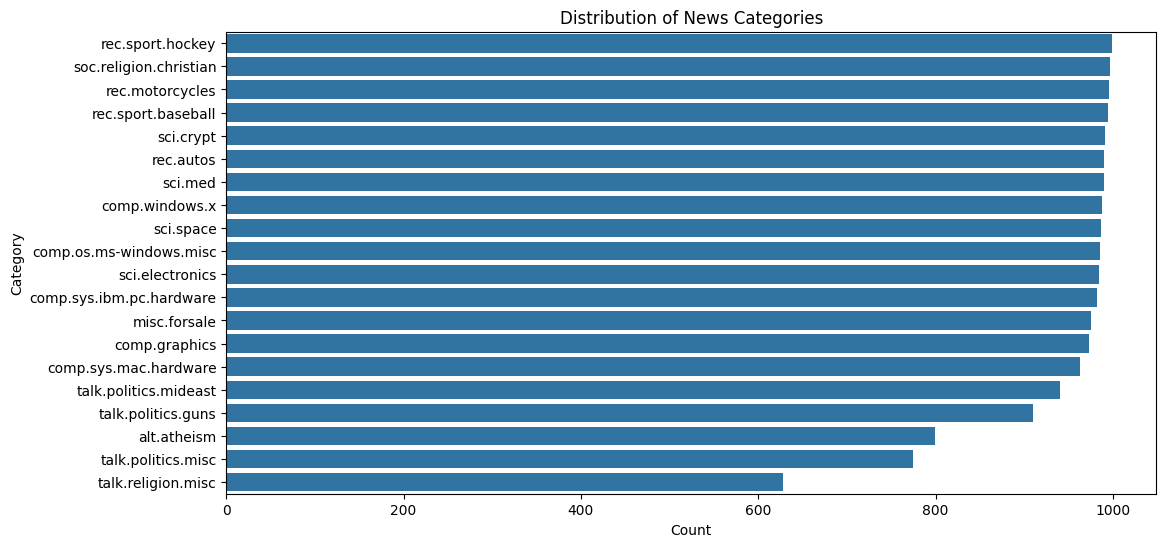

In [7]:
# Распределение классов
plt.figure(figsize=(12, 6))
sns.countplot(y='category', data=df, order=df['category'].value_counts().index)
plt.title('Distribution of News Categories')
plt.xlabel('Count')
plt.ylabel('Category')
plt.show()


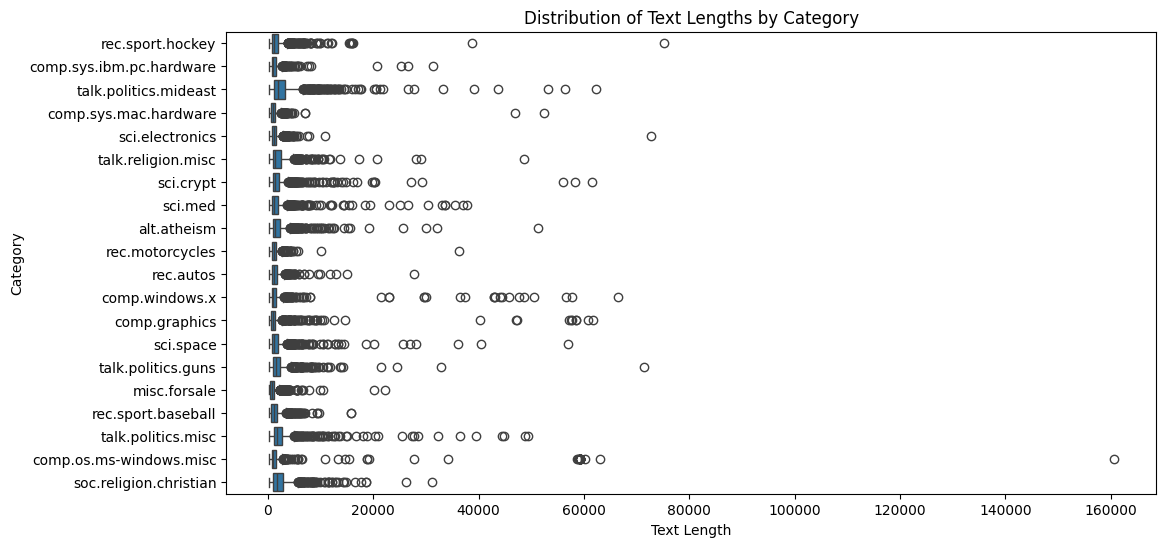

In [8]:
# Длина текстов в различных категориях
df['text_length'] = df['text'].apply(len)

plt.figure(figsize=(12, 6))
sns.boxplot(y='category', x='text_length', data=df, orient='h')
plt.title('Distribution of Text Lengths by Category')
plt.xlabel('Text Length')
plt.ylabel('Category')
plt.show()


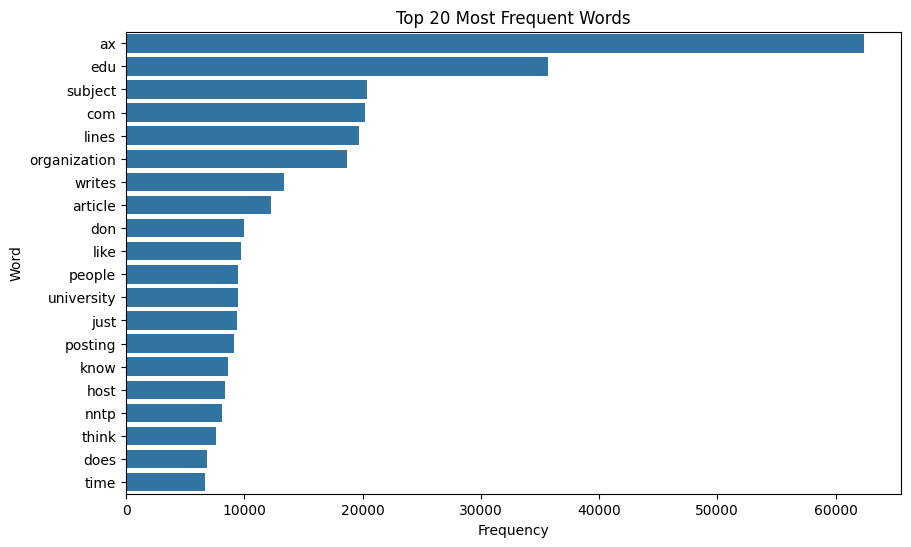

In [13]:
# Частотный анализ слов
vectorizer = CountVectorizer(stop_words='english', max_features=20)
X = vectorizer.fit_transform(df['text'])
# CountVectorizer — это инструмент из библиотеки scikit-learn, который преобразует текстовые данные в числовые векторы, подсчитывая частоту слов.
# stop_words='english' — удаляет стоп-слова (например, "the", "and", "is"), которые не несут значимой информации.
# max_features=20 — ограничивает количество анализируемых слов до 20 самых частых.
# X — это разреженная матрица (sparse matrix), где каждая строка соответствует документу (тексту), а каждый столбец — слову. Значения в матрице — это частоты слов.

# X.toarray(): Преобразует разреженную матрицу в плотный массив (numpy array), чтобы можно было легко суммировать частоты.
# sum(axis=0): Суммирует частоты слов по всем документам, создавая вектор частот,
# где каждая позиция соответствует суммарной частоте одного слова во всех документах.
word_freq = pd.DataFrame({
    'word': vectorizer.get_feature_names_out(),
    'frequency': X.toarray().sum(axis=0)
})

plt.figure(figsize=(10, 6))
sns.barplot(x='frequency', y='word', data=word_freq.sort_values(by='frequency', ascending=False))
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Word')
plt.show()


## Предобработка данных

In [14]:
# remove=('headers', 'footers', 'quotes') - из текстов будут удалены заголовки, подписи и цитаты.
newsgroups_data = fetch_20newsgroups(subset='all', remove=('headers', 'footers', 'quotes'))
# fetch_20newsgroups — загружает набор данных 20 Newsgroups, который содержит тексты новостных сообщений, разделенных на 20 категорий.
# subset='all' — загружает все данные (обучающие и тестовые).
# remove=('headers', 'footers', 'quotes') — удаляет из текстов заголовки, подписи и цитаты, чтобы оставить только основное содержание


# Удаление стоп-слов
def remove_stopwords(text):
    words = text.split()
    words = [word for word in words if word.lower() not in ENGLISH_STOP_WORDS]
    return ' '.join(words)
cleaned_texts = [remove_stopwords(text) for text in newsgroups_data.data]
# remove_stopwords — функция для удаления стоп-слов из текста.
  # text.split() — разбивает текст на слова.
  # [word for word in words if word.lower() not in ENGLISH_STOP_WORDS] — фильтрует слова, оставляя только те, которые не входят в список стоп-слов (ENGLISH_STOP_WORDS).
  # ' '.join(words) — объединяет оставшиеся слова обратно в текст.
# cleaned_texts — список текстов, очищенных от стоп-слов.


# Преобразование очищенного текста в TF-IDF признаки (будут выбраны только 5к наиболее значимых токенов)
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_features=5_000)
tfidf_features = tfidf_vectorizer.fit_transform(cleaned_texts)
# TfidfVectorizer — преобразует тексты в числовые признаки на основе TF-IDF (Term Frequency-Inverse Document Frequency).
# stop_words='english' — удаляет стоп-слова (дополнительно к уже удаленным в предыдущем шаге).
# max_features=5_000 — ограничивает количество признаков (токенов) до 5 000 самых значимых.
# tfidf_features — разреженная матрица (sparse matrix), где каждая строка соответствует тексту, а каждый столбец — TF-IDF значению для определенного слова.


# Преобразуем числовые метки категорий в строковые названия категорий
category_labels = [newsgroups_data.target_names[i] for i in newsgroups_data.target]
# newsgroups_data.target — массив числовых меток категорий для каждого текста.
# newsgroups_data.target_names — список строковых названий категорий.
# category_labels — список строковых названий категорий, соответствующих каждому тексту.


## Приминение методов понижения размерности

### PCA

In [18]:
pca = PCA(n_components=2, random_state=42)
# PCA — это метод уменьшения размерности, который проецирует данные на главные компоненты (направления с максимальной дисперсией).
# n_components=2 — количество компонент, на которые нужно уменьшить данные. В данном случае данные будут сжаты до 2 измерений (например, для визуализации на плоскости).
# random_state=42 — фиксирует случайное начальное состояние для воспроизводимости результатов.
pca_result = pca.fit_transform(tfidf_features.toarray())
# tfidf_features.toarray() — преобразует разреженную матрицу tfidf_features (полученную из TfidfVectorizer) в плотный массив (numpy array).
# Это необходимо, так как PCA работает с плотными массивами.
# fit_transform — выполняет два действия:
# fit — вычисляет главные компоненты на основе данных.
# transform — проецирует данные на эти компоненты.
# pca_result — это массив размерности (n_samples, 2), где каждая строка соответствует тексту, а столбцы — координатам в пространстве двух главных компонент.
# pca_result содержит координаты текстов в двумерном пространстве,

In [20]:
# Сколько информации сохранено в первых двух компонентах PCA
explained_variance = pca.explained_variance_ratio_
# explained_variance_ratio_ — это атрибут объекта PCA, который возвращает массив, содержащий долю объясненной дисперсии для каждой главной компоненты.
# Например, если explained_variance_ratio_ = [0.6, 0.3], это означает:
# Первая главная компонента объясняет 60% дисперсии данных.
# Вторая главная компонента объясняет 30% дисперсии данных.
total_explained_variance = explained_variance.sum()
# sum() — суммирует доли объясненной дисперсии для всех главных компонент.
# В примере выше: 0.6 + 0.3 = 0.9, то есть 90% дисперсии данных сохраняется после уменьшения размерности.
print(f'PCA - Total Explained Variance (information retained): {total_explained_variance:.2f}')
# Этот код показывает, какая часть информации (дисперсии) данных сохраняется после уменьшения размерности с помощью PCA. Например:
# Если total_explained_variance = 0.90, это означает, что 90% информации сохранилось, а 10% было потеряно.
# Если total_explained_variance = 0.50, это означает, что только 50% информации сохранилось, и, возможно, уменьшение размерности до 2 компонент не является оптимальным.


PCA - Total Explained Variance (information retained): 0.01


0.01 (то есть 1%), это означает, что после уменьшения размерности до 2 компонент с помощью PCA сохранилось только 1% информации (дисперсии) исходных данных. Это очень низкий показатель, и из него можно сделать несколько важных выводов:
1. Данные слишком сложны для представления в 2D
PCA пытается сохранить максимальную дисперсию данных, проецируя их на главные компоненты. Однако, если данные имеют сложную структуру (например, высокоразмерные или нелинейные), то 2 компоненты могут быть недостаточны для их описания.

Вывод: Уменьшение размерности до 2 компонент неэффективно для этих данных.
2. Потеря значительной части информации
Сохранение только 1% дисперсии означает, что 99% информации было потеряно. Это делает данные практически непригодными для анализа или визуализации в 2D.

Вывод: Результаты PCA в 2D не отражают реальную структуру данных.

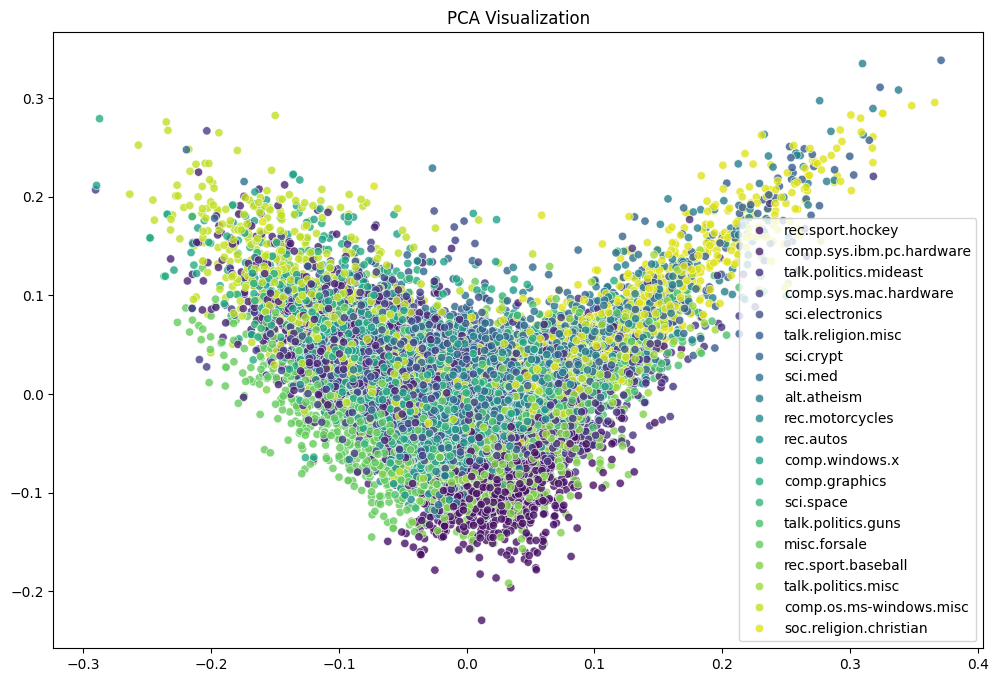

In [21]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('PCA Visualization')
plt.show()

### t-SNE

In [22]:
tsne = TSNE(n_components=2, random_state=42)
# TSNE — это метод уменьшения размерности, который особенно хорошо подходит для визуализации высокоразмерных данных в 2D или 3D.
# n_components=2 — количество компонент, на которые нужно уменьшить данные. В данном случае данные будут сжаты до 2 измерений для визуализации на плоскости.
# random_state=42 — фиксирует случайное начальное состояние для воспроизводимости результатов.

tsne_result = tsne.fit_transform(tfidf_features.toarray())
# tfidf_features.toarray() — преобразует разреженную матрицу tfidf_features (полученную из TfidfVectorizer) в плотный массив (numpy array). Это необходимо, так как t-SNE работает с плотными массивами.
# fit_transform — выполняет два действия:
# fit — обучает модель t-SNE на данных.
# transform — проецирует данные на 2D пространство.
# tsne_result — это массив размерности (n_samples, 2), где каждая строка соответствует тексту, а столбцы — координатам в 2D пространстве.

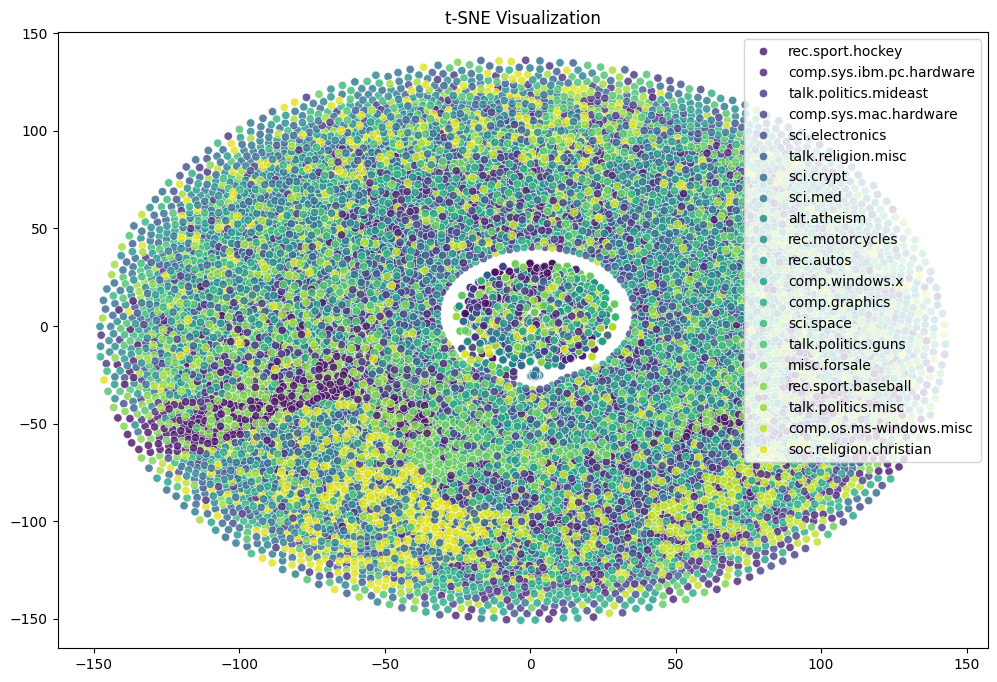

In [23]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=tsne_result[:, 0], y=tsne_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('t-SNE Visualization')
plt.show()

### UMAP  

In [24]:
umap = UMAP(n_components=2, random_state=42)
# UMAP(n_components=2): Создает объект UMAP, который будет понижать размерность данных до 2 компонентов. Это означает,
# что после применения UMAP, данные будут представлены в двумерном пространстве.
umap_result = umap.fit_transform(tfidf_features.toarray())


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


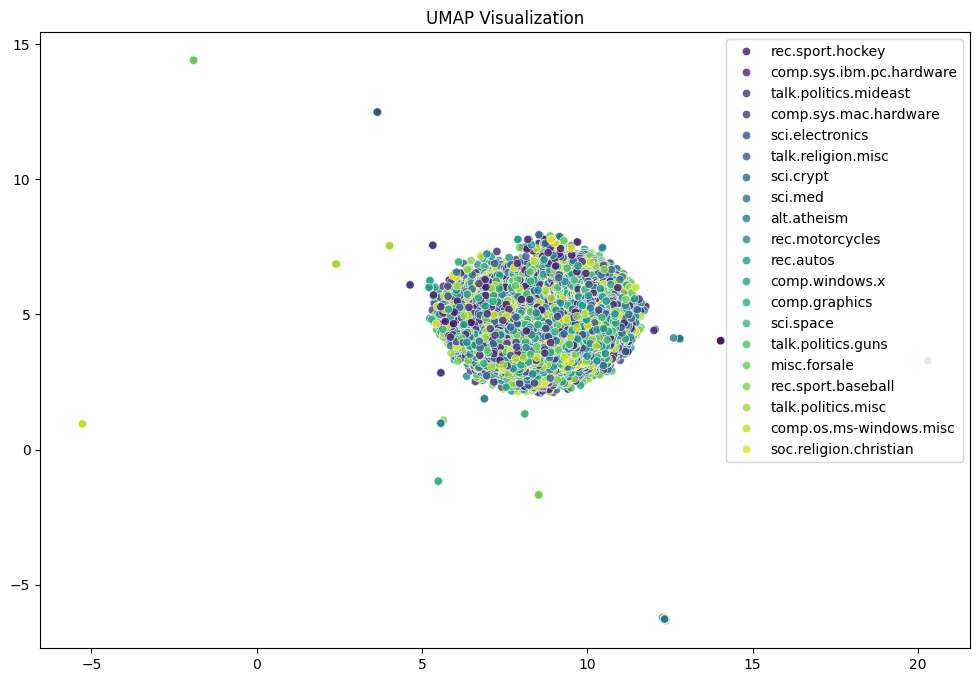

In [25]:
plt.figure(figsize=(12, 8))
sns.scatterplot(x=umap_result[:, 0], y=umap_result[:, 1], hue=category_labels, palette='viridis', legend='full', alpha=0.8)
plt.title('UMAP Visualization')
plt.show()


## Разделение данных на тренировочную и тестовую выборки

In [26]:
X_train, X_test, y_train, y_test = train_test_split(tfidf_features, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne = train_test_split(tsne_result, newsgroups_data.target, test_size=0.2, random_state=42)
X_train_umap, X_test_umap, y_train_umap, y_test_umap = train_test_split(umap_result, newsgroups_data.target, test_size=0.2, random_state=42)
# train_test_split — функция из библиотеки scikit-learn, которая разделяет данные на обучающую и тестовую выборки.
# tfidf_features — исходные TF-IDF признаки.
# pca_result — данные, уменьшенные до 2 компонент с помощью PCA.
# tsne_result — данные, уменьшенные до 2 компонент с помощью t-SNE.
# umap_result — данные, уменьшенные до 2 компонент с помощью UMAP.
# newsgroups_data.target — метки категорий (целевая переменная).
# test_size=0.2 — 20% данных будут использованы для тестирования, 80% — для обучения.
# random_state=42 — фиксирует случайное начальное состояние для воспроизводимости результатов.


# Получение размеров данных
def get_shape(X):
    if hasattr(X, 'shape'):
        return X.shape[0]  # Размер первой размерности (количество примеров)
    else:
        return len(X)  # Для плотных матриц
# get_shape — вспомогательная функция, которая возвращает количество примеров в данных.
# Если данные представлены в виде массива или разреженной матрицы (например, tfidf_features), используется атрибут shape.
# Если данные представлены в виде списка или плотного массива (например, pca_result, tsne_result, umap_result), используется функция len.



print(f"Размер X_train: {get_shape(X_train)}")
print(f"Размер X_test: {get_shape(X_test)}")
print(f"Размер y_train: {len(y_train)}")
print(f"Размер y_test: {len(y_test)}")

print(f"Размер X_train_pca: {get_shape(X_train_pca)}")
print(f"Размер X_test_pca: {get_shape(X_test_pca)}")
print(f"Размер y_train_pca: {len(y_train_pca)}")
print(f"Размер y_test_pca: {len(y_test_pca)}")

print(f"Размер X_train_tsne: {get_shape(X_train_tsne)}")
print(f"Размер X_test_tsne: {get_shape(X_test_tsne)}")
print(f"Размер y_train_tsne: {len(y_train_tsne)}")
print(f"Размер y_test_tsne: {len(y_test_tsne)}")

print(f"Размер X_train_umap: {get_shape(X_train_umap)}")
print(f"Размер X_test_umap: {get_shape(X_test_umap)}")
print(f"Размер y_train_umap: {len(y_train_umap)}")
print(f"Размер y_test_umap: {len(y_test_umap)}")


Размер X_train: 15076
Размер X_test: 3770
Размер y_train: 15076
Размер y_test: 3770
Размер X_train_pca: 15076
Размер X_test_pca: 3770
Размер y_train_pca: 15076
Размер y_test_pca: 3770
Размер X_train_tsne: 15076
Размер X_test_tsne: 3770
Размер y_train_tsne: 15076
Размер y_test_tsne: 3770
Размер X_train_umap: 15076
Размер X_test_umap: 3770
Размер y_train_umap: 15076
Размер y_test_umap: 3770


## Обучение моделей логистической регрессии

In [34]:
# Функция для обучения модели и оценки метрик
def evaluate_model(X_train, X_test, y_train, y_test):
  # Функция принимает четыре аргумента:
  # X_train — обучающие данные (признаки).
  # X_test — тестовые данные (признаки).
  # y_train — метки для обучающих данных.
  # y_test — метки для тестовых данных.
    classifier = LogisticRegression(max_iter=1000, random_state=42)
  # LogisticRegression — модель логистической регрессии из библиотеки scikit-learn.
  # max_iter=1000 — максимальное количество итераций для сходимости алгоритма. Увеличено до 1000, чтобы избежать предупреждений о недостижении сходимости.
  # random_state=42 — фиксирует случайное начальное состояние для воспроизводимости результатов.
    classifier.fit(X_train, y_train)
  # fit — обучает модель на обучающих данных (X_train, y_train).
    y_pred = classifier.predict(X_test)
  # predict — использует обученную модель для предсказания меток на тестовых данных (X_test).
    accuracy = accuracy_score(y_test, y_pred)
  # accuracy_score — вычисляет точность (accuracy), то есть долю правильных предсказаний.
    f1 = f1_score(y_test, y_pred, average='weighted') #average='weighted' - взвешенное среднее
  # accuracy — точность модели. f1 — F1-мера модели.
    return accuracy, f1


In [35]:
accuracy, f1 = evaluate_model(X_train, X_test, y_train, y_test)
accuracy_pca, f1_pca = evaluate_model(X_train_pca, X_test_pca, y_train_pca, y_test_pca)
accuracy_tsne, f1_tsne = evaluate_model(X_train_tsne, X_test_tsne, y_train_tsne, y_test_tsne)
accuracy_umap, f1_umap = evaluate_model(X_train_umap, X_test_umap, y_train_umap, y_test_umap)

print(f'Без понижения размерности - Accuracy: {accuracy:.2f}, F1-score: {f1:.2f}')
print(f'PCA - Accuracy: {accuracy_pca:.2f}, F1-score: {f1_pca:.2f}')
print(f't-SNE - Accuracy: {accuracy_tsne:.2f}, F1-score: {f1_tsne:.2f}')
print(f'UMAP - Accuracy: {accuracy_umap:.2f}, F1-score: {f1_umap:.2f}')


Без понижения размерности - Accuracy: 0.69, F1-score: 0.69
PCA - Accuracy: 0.21, F1-score: 0.13
t-SNE - Accuracy: 0.08, F1-score: 0.04
UMAP - Accuracy: 0.05, F1-score: 0.03


1. Без понижения размерности (TF-IDF)
Accuracy: 0.69, F1-score: 0.69

Модель показывает умеренную точность и F1-меру. Это означает, что TF-IDF признаки достаточно хорошо представляют текстовые данные для задачи классификации.

Однако точность 0.69 указывает на то, что модель ошибается примерно в 31% случаев. Это может быть связано с:

Сложностью данных (например, тексты могут быть слишком похожими между категориями).

Недостаточным количеством данных для обучения.

Неоптимальными гиперпараметрами модели.

2. PCA
Accuracy: 0.21, F1-score: 0.13

Точность и F1-мера значительно ниже, чем у исходных данных. Это связано с тем, что PCA уменьшает размерность до 2 компонент, что приводит к потере большого количества информации.

PCA сохраняет глобальную структуру данных, но для задачи классификации этого недостаточно, особенно если данные имеют сложную структуру.

3. t-SNE
Accuracy: 0.08, F1-score: 0.04

Результаты ещё хуже, чем у PCA. Это ожидаемо, так как t-SNE фокусируется на сохранении локальной структуры данных (близкие точки остаются близкими), но искажает глобальную структуру.

t-SNE не предназначен для задач классификации, и его использование для уменьшения размерности перед обучением модели приводит к плохим результатам.

4. UMAP
Accuracy: 0.05, F1-score: 0.03

Результаты хуже, чем у PCA и t-SNE. Это может быть связано с тем, что UMAP также фокусируется на локальной структуре данных, хотя и лучше сохраняет глобальную структуру, чем t-SNE.

Как и t-SNE, UMAP не подходит для задач классификации при уменьшении размерности до 2 компонент.

Основные выводы
TF-IDF признаки работают лучше всего:

Точность и F1-мера (0.69) значительно выше, чем у других методов.

Это подтверждает, что текстовые данные лучше всего представлять в виде TF-IDF признаков для задач классификации.

Уменьшение размерности до 2 компонент ухудшает результаты:

PCA, t-SNE и UMAP теряют слишком много информации при уменьшении размерности до 2 компонент.

Это делает их непригодными для задач классификации в таком виде.

t-SNE и UMAP не подходят для классификации:

Эти методы предназначены для визуализации данных, а не для обучения моделей.

Их использование для уменьшения размерности перед классификацией приводит к крайне низкой точности.

PCA может быть полезен, но с большим числом компонент:

Если увеличить число компонент (например, до 50 или 100), PCA может сохранить больше информации и улучшить результаты.

Рекомендации
Используйте TF-IDF признаки:

Они показывают наилучшие результаты для задачи классификации.

Попробуйте улучшить модель, настроив гиперпараметры (например, регуляризацию в логистической регрессии) или используя более сложные модели (например, случайный лес или градиентный бустинг).

Увеличьте число компонент в PCA:

Попробуйте уменьшить размерность до 50 или 100 компонент с помощью PCA и оцените результаты.

Это может сохранить больше информации и улучшить точность.

Используйте t-SNE и UMAP только для визуализации:

Эти методы лучше подходят для визуализации данных в 2D или 3D, а не для обучения моделей.

Попробуйте другие методы уменьшения размерности:

Например, TruncatedSVD или NMF (неотрицательная матричная факторизация) могут быть более подходящими для текстовых данных.

Исследуйте данные:

Проверьте, есть ли в данных дисбаланс классов или шум, который может ухудшать результаты.

Попробуйте улучшить предобработку текстов (например, лемматизация, удаление стоп-слов).

In [36]:
# Увеличиваем число компонент в PCA
pca = PCA(n_components=50, random_state=42)
pca_result = pca.fit_transform(tfidf_features.toarray())

# Разделение данных
X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(pca_result, newsgroups_data.target, test_size=0.2, random_state=42)

# Оценка модели
accuracy_pca, f1_pca = evaluate_model(X_train_pca, X_test_pca, y_train_pca, y_test_pca)
print(f'PCA (50 компонент) - Accuracy: {accuracy_pca:.2f}, F1-score: {f1_pca:.2f}')

PCA (50 компонент) - Accuracy: 0.56, F1-score: 0.56


Результат PCA (50 компонент) - Accuracy: 0.56, F1-score: 0.56 показывает, что увеличение числа компонент в PCA до 50 значительно улучшило производительность модели по сравнению с PCA на 2 компонентах (где Accuracy была 0.21, а F1-score — 0.13).

1. Улучшение по сравнению с PCA на 2 компонентах
Accuracy: 0.56 (против 0.21)

F1-score: 0.56 (против 0.13)

Увеличение числа компонент до 50 позволило сохранить больше информации из исходных данных, что привело к значительному улучшению точности и F1-меры.

Это подтверждает, что PCA может быть полезен для уменьшения размерности, но только если число компонент достаточно велико.

2. Сравнение с исходными данными (TF-IDF)
TF-IDF: Accuracy: 0.69, F1-score: 0.69

PCA (50 компонент): Accuracy: 0.56, F1-score: 0.56

PCA с 50 компонентами всё ещё уступает исходным TF-IDF признакам по точности и F1-мере.

Это связано с тем, что PCA теряет часть информации даже при увеличении числа компонент.

3. Интерпретация результата
PCA с 50 компонентами сохраняет достаточно информации для достижения умеренной точности (0.56).

Это может быть полезно, если требуется уменьшить размерность данных для ускорения обучения модели или уменьшения переобучения.

Однако для достижения максимальной точности лучше использовать исходные TF-IDF признаки.
